# First iteration of tree-based models.

The hyperparameter optization process will be the following:
1. Choose first range for hyperparameters.
2. Train n models using HalvingRandomSearchCV from scikit learn.
3. Pick the regions of the hyperparameter space that yield the best results.
4. Centre the hyperparameter search on those regions and iterate.

The scoring will consist in:
1. Numerical scores for the testing subset: recall, precision, roc_auc, f1.
2. Numerical scores for the whole data: recall, precision, roc_auc, f1.
2. Visualization of the ROC curve for the whole data.
4. Confusion matrix for the whole data.

In this way we can see if each model over/underfits, comparing the test and total scores. Also, the ROC curve and the confusion matrix will show how each model is performing in the whole dataset.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# For random number generation
from scipy.stats import randint, uniform

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold

# Some auxiliary functions for scoring.
import scoring_utils

#DEV
import importlib as imp


In [2]:
# Import the dataframe cleaned and encoded during the feature importance process.
df_encoded = pd.read_csv('../data/df_encoded.csv')

In [3]:
target = 'Default'
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
# Our target and features are the same that we employed during the importance analysis.
print(f"Target: {target}")
print(f"Features: {features_encoded}")

Target: Default
Features: ['Term', 'isNewBusiness', 'isFranchise', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBARatio', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [4]:
# This split will be used in every model, so that they are scored against the same subset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)
# Complete datasets
X_total = df_encoded[features_encoded]
y_total = df_encoded[target]

### Single Decision Tree Classifier

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Grid of parameters for a single tree
param_grid = [
    {
        "min_samples_split": randint(100, 200),
        "max_depth": randint(14, 18)
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingRandomSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    n_candidates=1000
)

single_tree_search.fit(X_train, y_train)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 10
min_resources_: 36
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 36
Fitting 9 folds for each of 1000 candidates, totalling 9000 fits


/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/s

----------
iter: 1
n_candidates: 334
n_resources: 108
Fitting 9 folds for each of 334 candidates, totalling 3006 fits
----------
iter: 2
n_candidates: 112
n_resources: 324
Fitting 9 folds for each of 112 candidates, totalling 1008 fits
----------
iter: 3
n_candidates: 38
n_resources: 972
Fitting 9 folds for each of 38 candidates, totalling 342 fits
----------
iter: 4
n_candidates: 13
n_resources: 2916
Fitting 9 folds for each of 13 candidates, totalling 117 fits
----------
iter: 5
n_candidates: 5
n_resources: 8748
Fitting 9 folds for each of 5 candidates, totalling 45 fits
----------
iter: 6
n_candidates: 2
n_resources: 26244
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=DecisionTreeClassifier(), n_candidates=1000,
                      n_jobs=-1,
                      param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x141139190>,
                                            'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x141176450>}],
                      scoring='recall', verbose=1)

In [6]:
scoring_utils.get_best_kernels(single_tree_search.cv_results_).head(10)

,params,rank_test_score,mean_test_score
kernel,,,
14_109,"{'max_depth': 14, 'min_samples_split': 109}",1,0.730137
16_110,"{'max_depth': 16, 'min_samples_split': 110}",2,0.729708
16_110,"{'max_depth': 16, 'min_samples_split': 110}",3,0.656538
14_109,"{'max_depth': 14, 'min_samples_split': 109}",4,0.656145
17_114,"{'max_depth': 17, 'min_samples_split': 114}",5,0.654179
15_111,"{'max_depth': 15, 'min_samples_split': 111}",5,0.654179
17_120,"{'max_depth': 17, 'min_samples_split': 120}",7,0.647905
17_119,"{'max_depth': 17, 'min_samples_split': 119}",7,0.647905
17_119,"{'max_depth': 17, 'min_samples_split': 119}",7,0.647905


In [7]:
# Let's use the best estimator to obtain test and overall scores 
single_tree_model = single_tree_search.best_estimator_

yhat_test = single_tree_model.predict(X_test)
yhat_total = single_tree_model.predict(X_total)

In [8]:
single_tree_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Single Tree Test")
single_tree_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Single Tree Total")

single_tree_score = pd.concat((single_tree_test_score, single_tree_total_score))
single_tree_score

,Recall,Precision,ROC,F1
Single Tree Test,0.791913,0.828124,0.879002,0.809614
Single Tree Total,0.801038,0.836374,0.884304,0.818325


In [9]:
yhat_baseline = pd.read_csv('../data/baseline_predict.csv')
scoring_utils.get_metrics(y_total, yhat_baseline, "Baseline")

,Recall,Precision,ROC,F1
Baseline,0.789368,0.83201,0.878192,0.810128


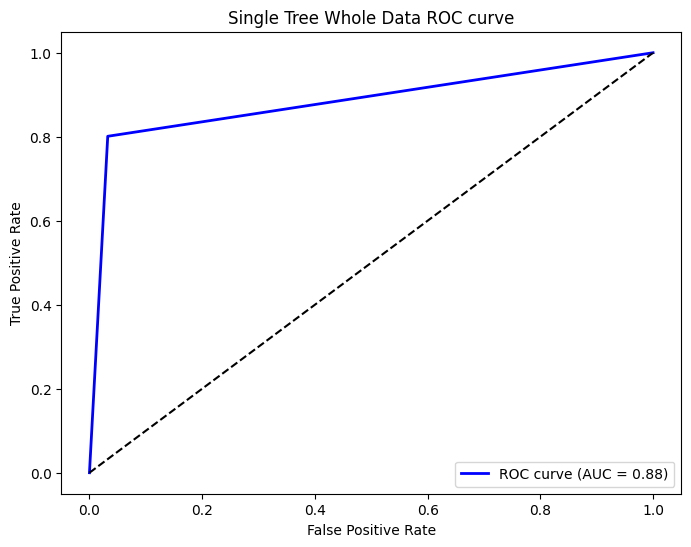

In [10]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Single Tree Whole Data")

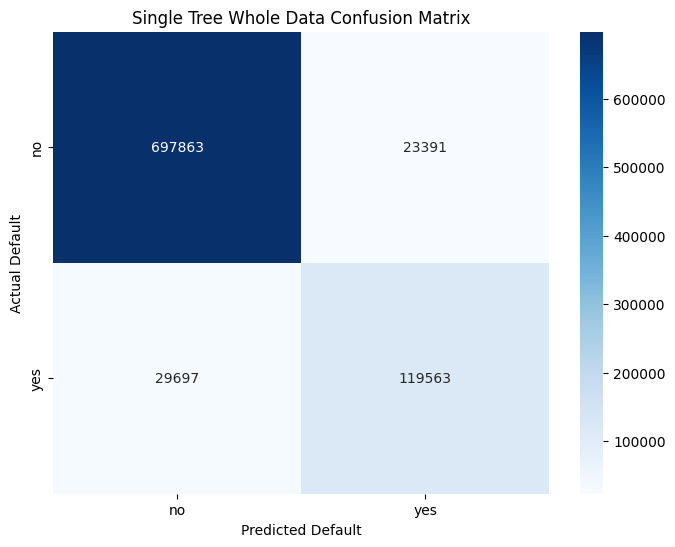

In [11]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Single Tree Whole Data")

### Bagging classifier

In [12]:
from sklearn.ensemble import Bala

# {'max_depth': 14, 'min_samples_split': 109} # One of my best trees!!!!!

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': [0.90, 0.92, 0.95, 1.0]
}

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

bagging_search = HalvingRandomSearchCV(
    estimator=BaggingClassifier(single_tree_model),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    n_candidates=50
)

bagging_search.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 10
min_resources_: 36
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 36
Fitting 9 folds for each of 16 candidates, totalling 144 fits


/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py

----------
iter: 1
n_candidates: 6
n_resources: 108
Fitting 9 folds for each of 6 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 2
n_resources: 324
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                                                   min_samples_split=109)),
                      n_candidates=50, n_jobs=-1,
                      param_distributions={'max_features': [0.9, 0.92, 0.95,
                                                            1.0],
                                           'n_estimators': [50, 100, 200, 500]},
                      scoring='recall', verbose=1)

In [13]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
200_1.0,"{'n_estimators': 200, 'max_features': 1.0}",1,0.404435
500_1.0,"{'n_estimators': 500, 'max_features': 1.0}",2,0.404171
500_1.0,"{'n_estimators': 500, 'max_features': 1.0}",3,0.000000
200_1.0,"{'n_estimators': 200, 'max_features': 1.0}",3,0.000000
100_1.0,"{'n_estimators': 100, 'max_features': 1.0}",3,0.000000
50_1.0,"{'n_estimators': 50, 'max_features': 1.0}",3,0.000000
500_0.95,"{'n_estimators': 500, 'max_features': 0.95}",3,0.000000
200_0.95,"{'n_estimators': 200, 'max_features': 0.95}",3,0.000000
500_1.0,"{'n_estimators': 500, 'max_features': 1.0}",3,0.000000


In [14]:
# Let's use the best estimator to obtain test and overall scores 
bagging_model = bagging_search.best_estimator_

yhat_test = bagging_model.predict(X_test)
yhat_total = bagging_model.predict(X_total)

In [17]:
bagging_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Bagging Test")
bagging_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Bagging Total")

bagging_score = pd.concat((bagging_test_score, bagging_total_score, single_tree_score))
bagging_score

,Recall,Precision,ROC,F1
Bagging Test,0.795339,0.835285,0.881491,0.814822
Bagging Total,0.802392,0.839408,0.885312,0.820482
Single Tree Test,0.791913,0.828124,0.879002,0.809614
Single Tree Total,0.801038,0.836374,0.884304,0.818325


In [19]:
yhat_baseline = pd.read_csv('../data/baseline_predict.csv')
scoring_utils.get_metrics(y_total, yhat_baseline, "Baseline")

,Recall,Precision,ROC,F1
Baseline,0.789368,0.83201,0.878192,0.810128


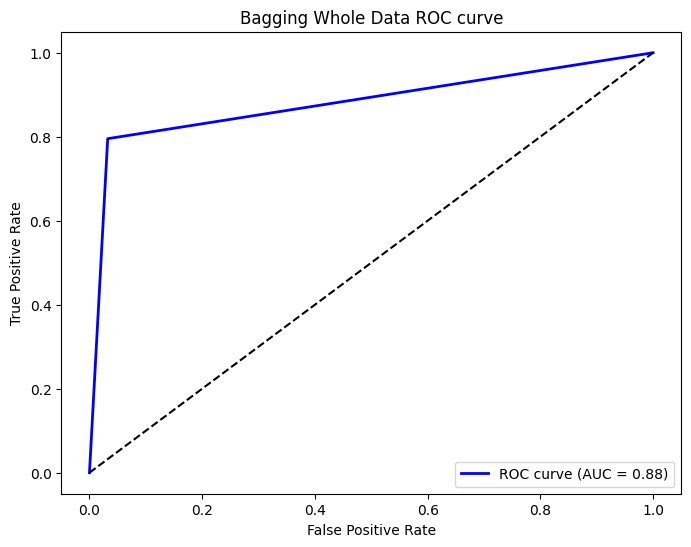

In [21]:
scoring_utils.get_roc_plot(y_test, yhat_test, "Bagging Whole Data")

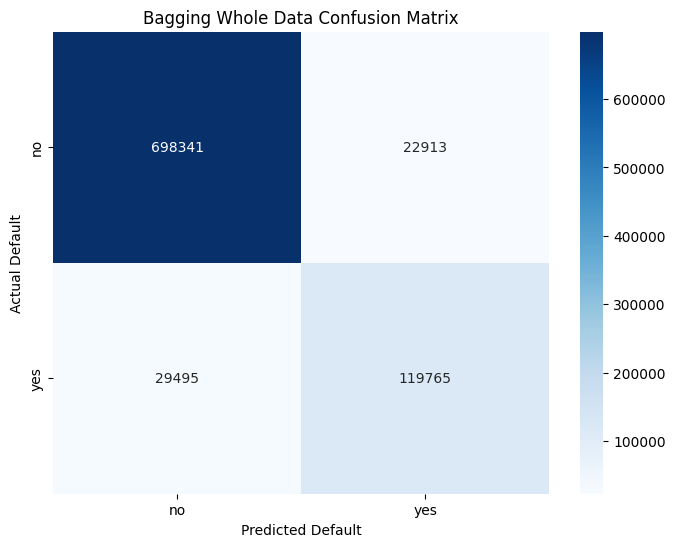

In [22]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")

### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

# {'max_depth': 14, 'min_samples_split': 109} # One of my best trees!!!!!

param_grid = {
    'max_depth': randint(12, 16),
    'min_samples_split': randint(100, 200),
    'n_estimators': randint(100, 500)
}

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

random_forest_search = HalvingRandomSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    n_candidates=50
)

random_forest_search.fit(X_train, y_train)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 10
min_resources_: 36
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 36
Fitting 9 folds for each of 50 candidates, totalling 450 fits


/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/s

----------
iter: 1
n_candidates: 17
n_resources: 108
Fitting 9 folds for each of 17 candidates, totalling 153 fits
----------
iter: 2
n_candidates: 6
n_resources: 324
Fitting 9 folds for each of 6 candidates, totalling 54 fits
----------
iter: 3
n_candidates: 2
n_resources: 972
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=RandomForestClassifier(), n_candidates=50,
                      n_jobs=-1,
                      param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15151bb10>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15791fe90>,
                                           'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157957510>},
                      scoring='recall', verbose=1)

In [24]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
13_123_222,"{'max_depth': 13, 'min_samples_split': 123, 'n_estimators': 222}",1,0.0
13_139_269,"{'max_depth': 13, 'min_samples_split': 139, 'n_estimators': 269}",1,0.0
14_193_484,"{'max_depth': 14, 'min_samples_split': 193, 'n_estimators': 484}",1,0.0
13_188_328,"{'max_depth': 13, 'min_samples_split': 188, 'n_estimators': 328}",1,0.0
12_170_398,"{'max_depth': 12, 'min_samples_split': 170, 'n_estimators': 398}",1,0.0
...,...,...,...
14_119_325,"{'max_depth': 14, 'min_samples_split': 119, 'n_estimators': 325}",1,0.0
12_105_196,"{'max_depth': 12, 'min_samples_split': 105, 'n_estimators': 196}",1,0.0
14_142_285,"{'max_depth': 14, 'min_samples_split': 142, 'n_estimators': 285}",1,0.0


In [33]:
##### DEV

forest_alt =  BaggingClassifier(
    n_estimators= 100,
    estimator=single_tree_model
)

forest_alt.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                   min_samples_split=109),
                  n_estimators=100)

In [34]:
###### DEV

yhat_alt = forest_alt.predict(X_total)

scoring_utils.get_metrics(y_total, yhat_alt, "Alternative")

,Recall,Precision,ROC,F1
Alternative,0.802459,0.839595,0.885366,0.820607


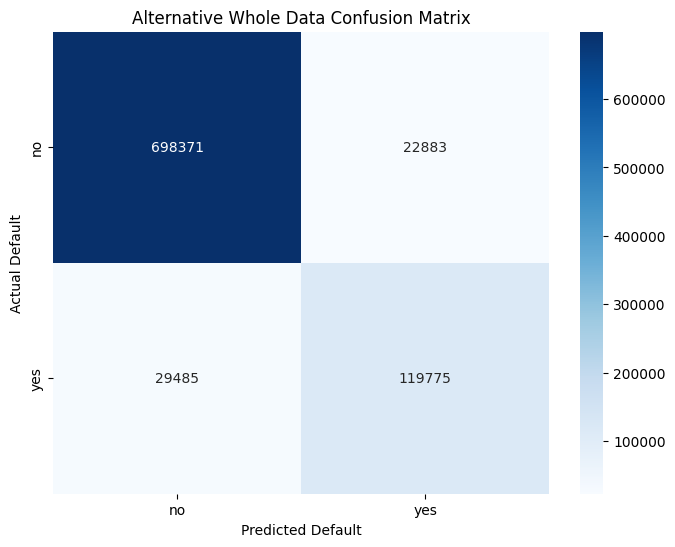

In [35]:
scoring_utils.get_confusion_matrix(y_total, yhat_alt, "Alternative Whole Data")

In [25]:
# Let's use the best estimator to obtain test and overall scores 
random_forest = bagging_search.best_estimator_

yhat_test = random_forest.predict(X_test)
yhat_total = random_forest.predict(X_total)

In [27]:
forest_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Random Forest Test")
forest_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Random Forest Total")

forest_score = pd.concat((forest_test_score, forest_total_score, bagging_score))
forest_score

,Recall,Precision,ROC,F1
Random Forest Test,0.578990,0.763440,0.770988,0.658543
Random Forest Total,0.584376,0.766346,0.773752,0.663104
Bagging Test,0.795339,0.835285,0.881491,0.814822
Bagging Total,0.802392,0.839408,0.885312,0.820482
Single Tree Test,0.791913,0.828124,0.879002,0.809614
Single Tree Total,0.801038,0.836374,0.884304,0.818325


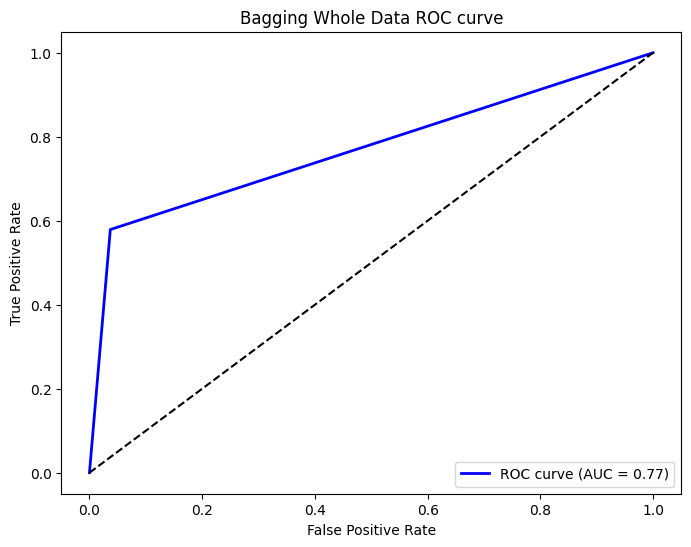

In [28]:
scoring_utils.get_roc_plot(y_test, yhat_test, "Bagging Whole Data")

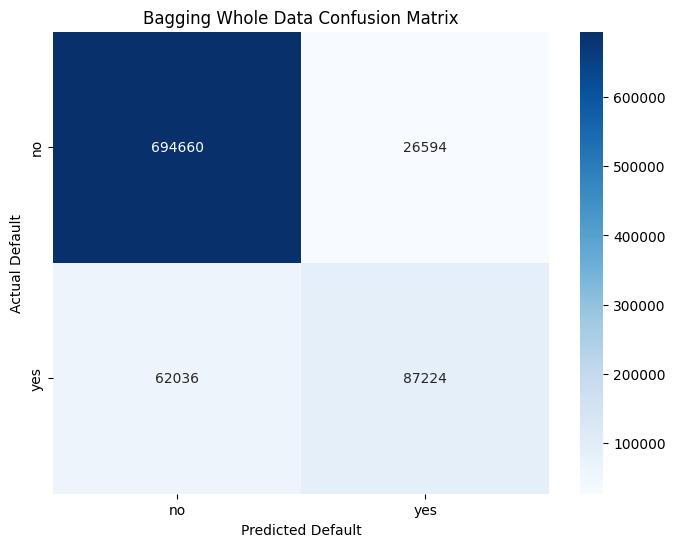

In [29]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")